<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/main/scikit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#pull in the single framed features
import pandas as pd
#This is the old results file with bad ROIs and the old stimulus values, need to use new features once extracted
df = pd.read_csv('/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/210815_0_1_label_mc_mix1_syt_features_1Frame_demo.csv')
#drop duplicates and sample just 5000 obs for speed, need more observations for actually training
df = df.drop(columns = ['Unnamed: 0']).drop_duplicates().sample(5000)
df.head()

,roi_ID,area,center_of_mass_row,center_of_mass_column,fluorescence,stimulus_demo,label
50621,210815_0_1_stackRaw_mc_mix1_syt_9,9.920591,26.478135,67.167647,9323.383498,0.226376,tm4
18489,210815_0_1_stackRaw_mc_mix1_syt_3,8.481344,46.690518,94.954937,0.000000,0.191518,tm2
49901,210815_0_1_stackRaw_mc_mix1_syt_9,9.920591,26.478135,67.167647,6925.918160,0.956460,tm4
36864,210815_0_1_stackRaw_mc_mix1_syt_6,7.805018,81.613108,115.277042,0.000000,-0.460496,tm1
7513,210815_0_1_stackRaw_mc_mix1_syt_1,9.489691,40.312613,82.219801,0.000000,0.133153,tm2


In [3]:
df['roi_ID'].value_counts()

210815_0_1_stackRaw_mc_mix1_syt_7    570
210815_0_1_stackRaw_mc_mix1_syt_8    514
210815_0_1_stackRaw_mc_mix1_syt_1    508
210815_0_1_stackRaw_mc_mix1_syt_0    501
210815_0_1_stackRaw_mc_mix1_syt_6    498
210815_0_1_stackRaw_mc_mix1_syt_9    494
210815_0_1_stackRaw_mc_mix1_syt_4    493
210815_0_1_stackRaw_mc_mix1_syt_3    481
210815_0_1_stackRaw_mc_mix1_syt_2    471
210815_0_1_stackRaw_mc_mix1_syt_5    470
Name: roi_ID, dtype: int64

In [4]:
df['sq_difference'] = (df['fluorescence']-df['stimulus_demo'])**2
X_df = df[['sq_difference']]
y = df['label']

Nearest Neighbors: score: 0.36933333333333335


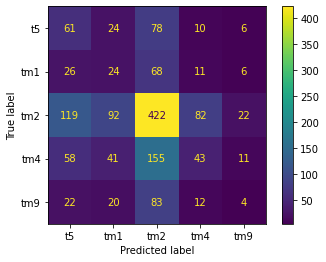

Linear SVM: score: 0.49133333333333334


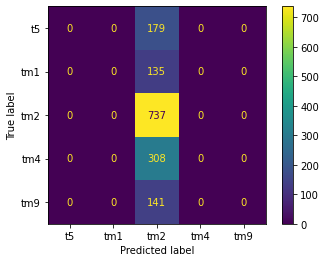

RBF SVM: score: 0.49466666666666664


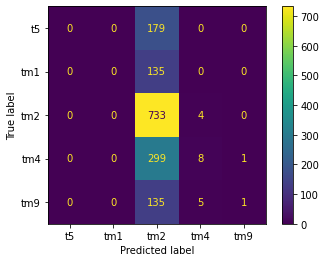

Gaussian Process: score: 0.49133333333333334


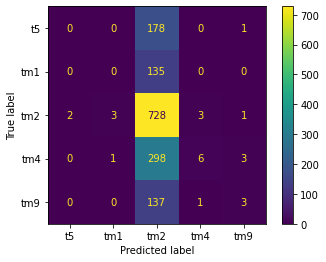

Decision Tree: score: 0.49466666666666664


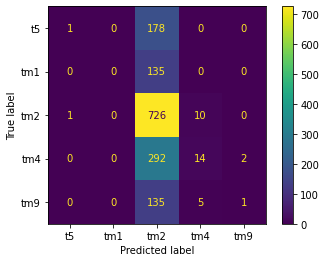

Random Forest: score: 0.49666666666666665


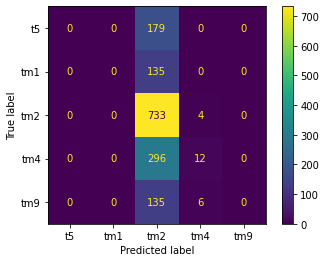

Neural Net: score: 0.49133333333333334


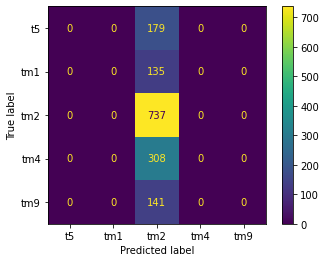

AdaBoost: score: 0.312


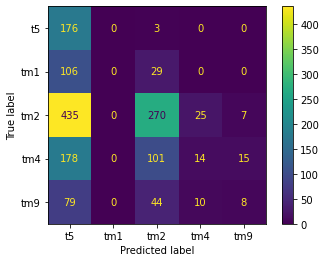

Naive Bayes: score: 0.312


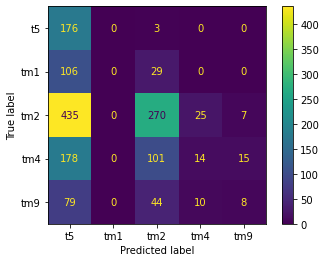

In [5]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=.01, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.3, random_state=101
)

#Scale based on X_train to avoid data leakage
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)

X = StandardScaler().fit_transform(X_df)

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f'{name}: score: {score}')

    preds = clf.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()


Elapsed time to compute the importances: 0.817 seconds


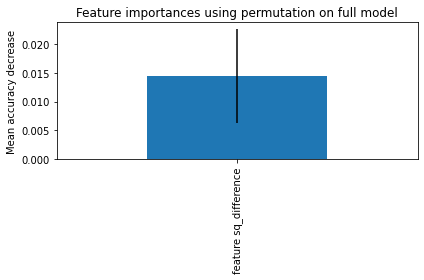

In [8]:
#useless when there's only 1 feature, but can be useful to see feature importance from RF model

from sklearn.inspection import permutation_importance
import time
feature_names = [f"feature {i}" for i in X_df.columns]
start_time = time.time()
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()